## Abstract

The ability to detect pitch in complex audio signals is a fundamental problem in signal processing, with applications ranging from music analysis to speech recognition. While human perception intuitively identifies pitch even in harmonically rich or noisy signals, translating this process into computational algorithms remains a challenge. This project explores the **YIN algorithm**, a widely cited pitch detection method, which combines autocorrelation with cumulative mean normalization to accurately extract periodicity from audio waveforms.

To test the algorithm's performance, a synthetic audio signal with realistic harmonic overtones was generated to closely mimic the complexity of musical instrument sounds. I extended the autocorrelation function to use FFT for faster computation. The implementation successfully estimated the fundamental frequency with high precision, producing a result of $440.06$ Hz for a signal with an expected pitch of $440$ Hz. This outcome demonstrates the effectiveness of the YIN algorithm in detecting pitch from non-trivial waveforms. Through this project, I strengthened my understanding of the mathematical/computational foundations of autocorrelation-based pitch detection.

## Introduction

### A very abridged physics of sound
When we listen to pitched sound, the 'pitch' of what we are hearing is often described in terms of frequency. This is because the way our ears perceive sound is through hearing the intensity (amplitude) and frequency at which the sound (a pressure wave) is hitting our eardrums. The simplest example is a pure sine wave, which we can easily manipulate the frequency of to produce different pitches.

However, these pure waves often sound 'harsh' and obviously synthetic. This is because in real life, and for most musical instruments, the actual generated wave is quite complex and consists of multiple waves interacting con/de-structively with each other to smoothen out the sound. And audio waves with no distinct noticable periodicity are often perceived not as pitched, but as 'noise'. This is again due to the lack of some distinct patterning frequency which our ears can attune to.

### Pitch detection algorithms
The goal of pitch detection algorithms is to parse together the often complex frequency waveforms to find the repeating unit of pitch which corresponds to the 'pitch'. Since humans have an innate subjective sense of pitch and for parsing out these complex waves in our own ears, we want the algorithm to also determine the pitch and recreate the processes happening in our brains, computationally.

My following project hopes to explore one of the most ubiquitously cited pitch detection algorithms - the YIN algorithm, and how it navigates the challenges of extracting periodicity from complex audio signals.

### Equations

The specifics of each computational method used are included in markdown in the Implementation section. However for reference, I am using the following equations:

1. Autocorrelation - The basis for time-based signal processing

$$r_t(\tau) = \sum^{t+W-\tau}_{j=t+1}x_j x_{j+\tau}$$

2. Wiener-Khinchin theorem - Faster autocorrelation with FFT

$$r_t(\tau) = \mathcal{F}^{-1}(x) \left ( \left | \mathcal{F}(x) \right |^2 \right )$$

3. Difference function - Variant of autocorrelation

$$d_t(\tau) = \sum^{t+W}_{j=t+1} (x_j - x_{j+T})^2$$

4. Cumulative Mean-Normalized Difference Function (CMNDF) - Variant of difference function, for peak-picking

$$
d_t'(\tau) =
\begin{cases}
    1, & \text{if } \tau = 0, \\
    \frac{d_t(\tau)}{\left[\frac{1}{\tau} \sum\limits_{j=1}^{\tau} d_t(j)\right]}, & \text{otherwise}.
\end{cases}
$$

5. Parabolic interpolation - To refine final pitch estimates

$$f(x) = Ax^2 + Bx + C$$

Equations 1, 3, 4 are from the YIN paper [1].

I explain my rationale for why each of these equations is significant to the final pitch detection algorithm more in-depth in the Implementation section.

---

### Create synthetic audio

Here, you can either load in your audio file of choice (place in the same directory), or run it with the testing synthetic audio.

Since the algorithm is intended for use on musical instruments, it is useful to consider those waveforms which display the same harmonic overtone qualities as certain actual musical signals. For example, stringed instruments have a harmonic series where the fundamental frequency is present in the waveform but in increasingly higher frequency multiples of the base frequency, and at lower amplitudes. This sometimes causes issues in pitch detection, as we will see later, but the YIN algorithm was designed with musical pitch detection in mind and has a couple measures baked in to help mitigate the influence of signal messiness.

In [ ]:
# pip install numpy matplotlib scipy ipython
import numpy as np 
# import librosa # optional, for if you want to load in your own audio
import matplotlib.pyplot as plt
import scipy.signal
import IPython.display as ipd

In [4]:
# alternative! load in your desired audio with librosa
# signal, SAMPLE_RATE = librosa.load('violin.mp3', sr=None)

# basic parameters
SAMPLE_RATE = 44100  # sampling rate
FRAME_SIZE = 4096

# synthetic audio generation
def create_signal(f0: float, duration: float):
    """
    Create a synthetic audio signal given a desired fundamental frequency and a duration.
    Simulates (poorly) the harmonic overtone series found in stringed instruments.

    Args:
        f0: The fundamental frequency to generate
        duration: How long the pitch should last
    """
    f0 = 440.0  # fundamental frequency (A4)
    duration = 2.0  # sec
    t = np.linspace(0, duration, int(SAMPLE_RATE * duration), endpoint=False)

    # create harmonic series
    harmonics = [1, 2, 3, 4, 5, 6, 7] 
    amplitudes = [1.0, 0.8, 0.6, 0.45, 0.2, 0.1, 0.05]  # each harmonic with decaying amplitude
    signal = np.zeros_like(t)

    for harmonic, amplitude in zip(harmonics, amplitudes):
        signal += amplitude * np.sin(2 * np.pi * harmonic * f0 * t)

    # add some noise
    noise = 0.02 * np.random.randn(len(t))  # Small random noise
    signal += noise

    # envelope parameters (sec)
    attack_time = 0.1
    decay_time = 0.3 
    release_time = 0.5 

    sustain_level = 0.7

    attack = np.linspace(0, 1, int(SAMPLE_RATE * attack_time))
    decay = np.linspace(1, sustain_level, int(SAMPLE_RATE * decay_time))
    sustain = np.ones(int(SAMPLE_RATE * (duration - attack_time - decay_time - release_time))) * sustain_level
    release = np.linspace(sustain_level, 0, int(SAMPLE_RATE * release_time))

    # concatenate the envelope parts
    envelope = np.concatenate([attack, decay, sustain, release])

    # adjust envelope length to match signal length
    if len(envelope) < len(signal):
        envelope = np.pad(envelope, (0, len(signal) - len(envelope)))  # Pad with zeros if too short
    elif len(envelope) > len(signal):
        envelope = envelope[: len(signal)]  # Trim if too long

    # apply the envelope
    signal *= envelope
    signal /= np.max(np.abs(signal)) # normalize

    return signal

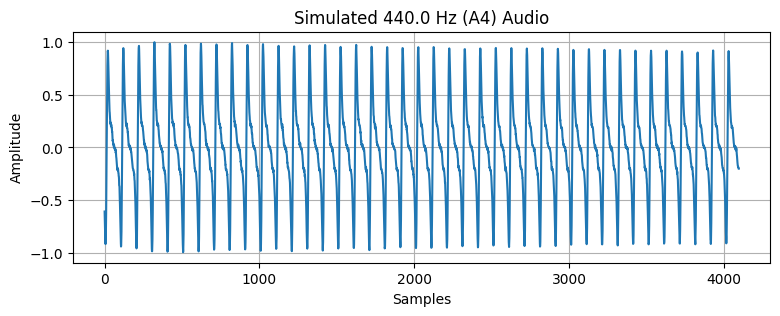

In [5]:
signal = create_signal(440, 2)
start_idx = FRAME_SIZE
end_idx = start_idx + FRAME_SIZE
audio_frame = signal[start_idx:end_idx]

# Plot the signal
plt.figure(figsize=(9, 3))
plt.plot(audio_frame)
plt.title("Simulated 440.0 Hz (A4) Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

ipd.Audio(signal, rate=SAMPLE_RATE)

# Pitch Detection: Autocorrelation

**Autocorrelation**-based methods represent one of the most popular categories of pitch detection algorithms, and is also the method which underlies the YIN algorithm. It tries to analyze the audio signal within the *time domain* by detecting how similar the signal is to a shifted version to itself.

### Problem statement
We have some audio signal $x$, represented as a numpy array of samples, where each sample contains a quantized representation of the pressure of the physical audio wave at the given time of 'sampling'.

**Basic idea:** We want to estimate the fundamental frequency $F_0$ for a given frame of audio data by comparing how different the original signal is to a signal shifted over by some lag. The specific lag which minimizes this difference, we call the fundamental period, which is equivalent to $1 / F_0$.

## Autocorrelation
We define the autocorrelation function $r_t(\tau)$ as a function of some $\tau$, which is a duration (in samples) of how much to x-shift each point in the curve by. 

The goal of this function is to identify those periods under which the function most resembles itself. The function multiplies each new pair of x's together (where $x_j$ represents the audio signal value at the $j$ th sample), so higher values represent a value of $\tau$ under which the curve looks more like itself.

$$r_t(\tau) = \sum^{t+W}_{j=t+1}x_j x_{j+\tau}$$

Equation from the YIN paper [1]

In the code, we use a slightly modified definition from the YIN paper [1] which defines a second slightly different definition which allows the integration window size to shrink with increasing values of $\tau$.

$$r_t(\tau) = \sum^{t+W-\tau}_{j=t+1}x_j x_{j+\tau}$$

This makes it so that larger $\tau$ values are weighted slightly less, under the assumption that the true fundamental frequency is closer to the origin point.

### FFT-enabled autocorrelation with Wiener-Khinchin
The **Wiener-Khinchin theorem** enables us to compute the autocorrelation much faster. We can rewrite the audio signal 'array' $x$ as a function $x(t)$ where $t$ is the index of the sample in the array. Then we can rewrite the autocorrelation function as an integral on this function $x(t)$ as such:

$$r_t(\tau) = \int^{\infty}_{\infty} \bar{x}(\tau)x(t+\tau) d\tau$$

where $\bar{x}(\tau)$ is the complex conjugate of $x$. A short proof of the theorem can be found at [[2](https://mathworld.wolfram.com/Wiener-KhinchinTheorem.html)], but the result that we are using for this autocorrelation implementation is the ability to compute the autocorrelation not by iterating through all possible samples for all possible frames and multiplying each sample pointwise, but rather it allows us to use the fast fourier transform which runs in $O(N \log n)$ time per frame, whereas the other method would be $O(N^2)$ per frame.

It suffices to compute:

$$r_t(\tau) = \mathcal{F}^{-1}(x) \left ( \left | \mathcal{F}(x) \right |^2 \right )$$

where $\mathcal{F}(x)$ is the fourier transform of the audio signal. Note $\left | \mathcal{F}(x) \right |^2$ is also how we define the power spectrum of the signal, which shows how much each individual frequency component is contributing to the audio waveform.

In [6]:
# define autocorrelation function
def autocorrelation_fft(audio_frame: np.ndarray, tau_max: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Fast autocorrelation function using Wiener-Khinchin theorem,
    which computes autocorrelation as the inverse FFT of the signal's power spectrum.

    Args:
        audio_frame: The current frame of audio samples in Yin algorithm
        tau_max: Check for all time lags up to this value for in autocorrelatioin

    Returns:
        autocorrelation: The similarity curve
        power_spec: The power spectrum of the frame
        amplitudes: Amplitudes of the frame
    """
    w = audio_frame.size
    tau_max = min(tau_max, w)  # ensure tau_max is within the window size

    # Zero-pad the audio signal array by the minimum power of 2 which
    # is larger than the window size + tau_max.
    # (circular instead of linear convolution, avoids errors)
    min_fft_size = w + tau_max  # (pad by >tau_max for frame end)

    p2 = (min_fft_size // 32).bit_length()
    fft_sizes = (16, 18, 20, 24, 25, 27, 30, 32)
    size_pad = min(size * (2 ** p2) for size in fft_sizes if size * 2 ** p2 >= min_fft_size)

    # -- Wiener-Khinchin Autocorrelation --
    # take FFT to decompose signal into its frequency components
    fft_frame = np.fft.rfft(audio_frame, size_pad)
    power_spectrum = fft_frame * fft_frame.conjugate()
    autocorrelation = np.fft.irfft(power_spectrum)[:tau_max]

    amplitudes = np.abs(fft_frame)

    # only return valid overlapping values up to window_size-tau_max
    # (type II autocorrelation from jasa 2002)
    return autocorrelation[:w-tau_max], power_spectrum, amplitudes

### Autocorrelation acts frame-by-frame

The autocorrelation function acts on the audio signal, and is often applied on a frame-by-frame basis. 

We define a frame as some window of samples, small enough so that the pitch remains relatively constant within this window, but large enough to capture the true fundamental period of the audio. 

Hence we say that we apply autocorrelation over a small window of samples where inside, the pitch does not change much. Then we can iterate through all frames in the audio signal in order to see how the pitch evolves over time.

In this notebook, I will show how the algorithm can act upon a single frame, but it can be, and often is, easily extended to compute the pitch across multiple frames on longer segments of audio as well.

Computing pitches with tau_max 225


/Users/sarah/Desktop/columbia/semester5/courses/numerical-methods/num-methods/num-venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/sarah/Desktop/columbia/semester5/courses/numerical-methods/num-methods/num-venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


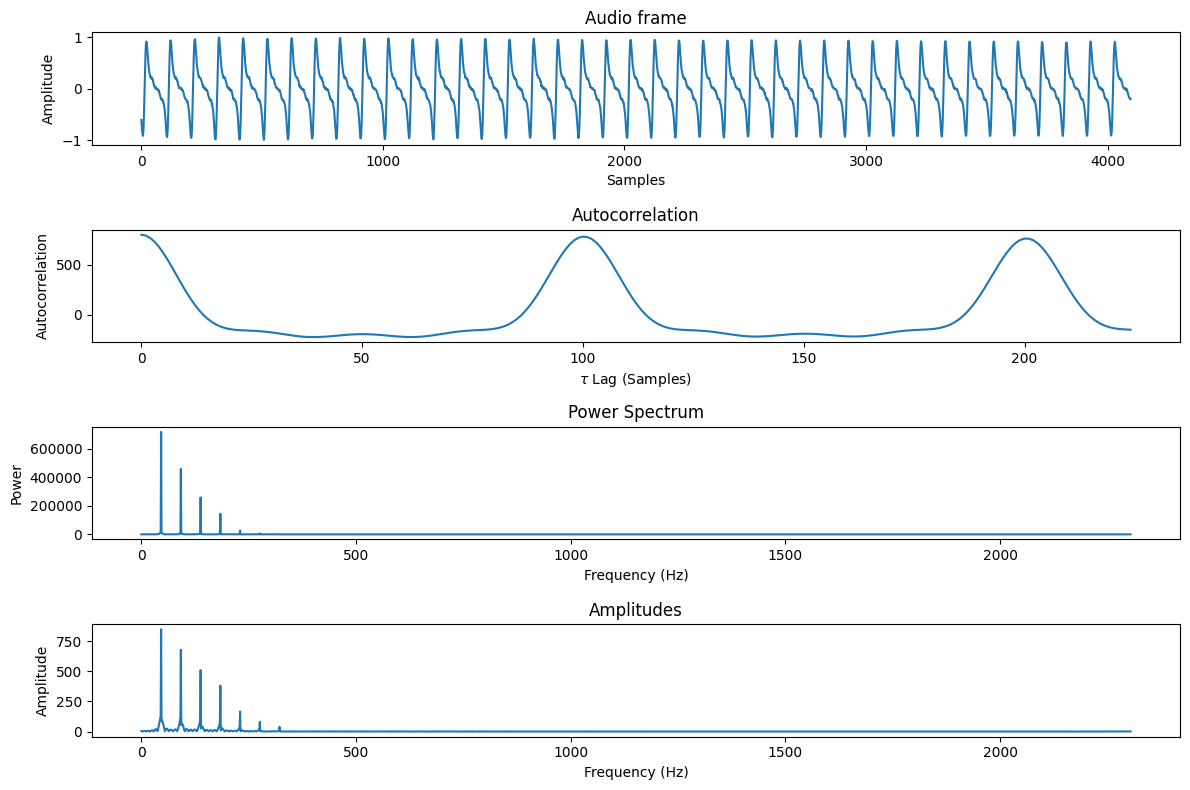

In [7]:
# define a minimum frequency to avoid picking up on noise
MIN_VIOLIN_FREQ = 196.0 # let's just use this becuase i like the violin
tau_max = int(SAMPLE_RATE/MIN_VIOLIN_FREQ)
print(f"Computing pitches with tau_max {tau_max}")

# call autocorrelation function
autocorr, power_spec, amplitudes = autocorrelation_fft(audio_frame, tau_max)

# plot the curves 🏔️ 🏔️
fig, axs = plt.subplots(4, 1, figsize=(12, 8))

axs[0].plot(audio_frame)
axs[0].set_title('Audio frame')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

axs[1].plot(autocorr)
axs[1].set_title('Autocorrelation')
axs[1].set_xlabel('$\\tau$ Lag (Samples)')
axs[1].set_ylabel('Autocorrelation')

axs[2].plot(power_spec)
axs[2].set_title('Power Spectrum')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('Power')

axs[3].plot(amplitudes)
axs[3].set_title('Amplitudes')
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('Amplitude')

fig.tight_layout()
plt.show()

ipd.Audio(audio_frame, rate=SAMPLE_RATE)

## YIN's CMNDF
YIN's unique contribution to autocorrelation-based pitch detection methods is its **cumulative mean-normalized difference function** (CMNDF). We will first define the raw difference function, then see how YIN modifies it, then see how we use the curve to detect periodicity in the audio signal.

### Background: The difference function
If we assume that the signal is periodic with some period $T$, we can construct an equality which we can solve to form a 'difference function' which is able to be minimized to find the period (or 'lag' in autocorrelation terms) under which the signal most closely resembles itself.

We can model a periodic signal $x$ with period $T$ to be by definition invariant when we shift it by that period:

$$x_t - x_{t+T} = 0 \quad \forall t$$

Which can be rewritten to still equal $0$ after squaring the result and summing the result over a window of different $t$ values. We use this fact to construct the following definition of the difference function $d_t(\tau)$, and search for values of $\tau$ which minimize this difference.

$$d_t(\tau) = \sum^{t+W}_{j=t+1} (x_j - x_{j+T})^2$$

Expanding, the RHS and substituting our definition of the autocorrelation function $r_t(\tau)$, we get the following equation for constructing the difference function:

$$
\begin{align*}
d_t(\tau)&= \sum^{t+W}_{j=t+1} x_j x_j - x_j x_{j+\tau} - 2x_j x_{j+\tau} \\
&=r_t(0)+r_{t+\tau}(0)-2r_t(\tau)
\end{align*}
$$

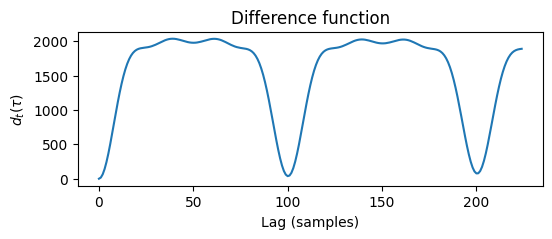

In [8]:
def difference_function(audio_frame: np.ndarray, tau_max: int):
    """
    Compute the raw difference function for the YIN algorithm without assuming constant energy.
    
    Args:
        audio_frame: The current frame of audio samples.
        tau_max: The maximum lag to compute up to.
        
    Returns:
        diff_fct: The difference function values for lags 0 to tau_max.
        power_spec: The power spectrum of the audio frame.
        amplitudes: Amplitudes of the frame.
    """
    x = np.array(audio_frame, dtype=np.float64)  # Ensure float64 precision
    w = x.size
    tau_max = min(tau_max, w)  # Ensure tau_max is within the window size

    # compute fast autocorrelation using FFT
    autocorr, power_spec, amplitudes = autocorrelation_fft(x, tau_max)

    # compute the energy (r_t(0) and r_{t+\tau}(0)) for each lag
    r_0 = np.sum(x**2)
    energy = np.full(autocorr.shape, r_0)

    diff_fct = energy[0] + energy - 2 * autocorr
    diff_fct[0] = 0

    return diff_fct, power_spec, amplitudes


diff_fct, power_spec, amplitudes = difference_function(audio_frame, tau_max)

fig = plt.figure(figsize=(6,2))
axs = fig.add_subplot(1, 1, 1)

axs.plot(diff_fct)
axs.set_title("Difference function")
axs.set_xlabel("Lag (samples)")
axs.set_ylabel("$d_t(\\tau)$")

plt.show()

# Trough-picking
Recall that the fundamental period ($1/f_0$) corresponds to the point in which this difference function is minimized. Thus we would want to pick out some minima ('troughs') within the above curve. But how do we choose which trough to call the fundamental period?

## Step 1: Cumulative mean normalization
The solution to this problem has multiple parts, but the first step is to modify the autocorrelation curve itself to bias against choosing lags near the beginning, and normalizing the range of the function.

The way the original YIN algorithm does this is through **cumulative mean normalization**. This is where we finally construct the CMNDF, which is given by the following equation (and as equation 8 in [1]):

$$
d_t'(\tau) =
\begin{cases}
    1, & \text{if } \tau = 0, \\
    \frac{d_t(\tau)}{\left[\frac{1}{\tau} \sum\limits_{j=1}^{\tau} d_t(j)\right]}, & \text{otherwise}.
\end{cases}
$$

The idea is to normalize each $d_t(\tau)$, $\forall \tau \in [0, \tau _{\text{max}}]$ by the 'cumulative mean' of all $d_t(\tau)$ values up until that point, and artificially set the zero lag value to have a difference of $1$.

In [9]:
def cmndf(audio_frame: np.ndarray, tau_max: int):
    """
    Cumulative Mean Normalized Difference Function (CMNDF).

    The idea is to normalize each d_t(tau) value for all lags based on the mean of the
    cumulative sum of all differences leading up to that point. YIN solution to not
    picking the zero-lag peak.

    Args:
        audio_frame: The current frame of audio samples in Yin algorithm
        tau_max: Check for all time lags up to this value for in autocorr

    Returns:
        cmndf: Array of values where index=tau and value=CMNDF(tau)
        power_spec: The power spectrum of the audio frame
        amplitudes: Amplitudes of the frame
    """
    x = np.array(audio_frame, np.float64)
    w = x.size # window size
    tau_max = min(tau_max, w)  # ensure tau_max is within the window size

    # compute difference function
    diff_fct, power_spec, amplitudes = difference_function(x, tau_max)

    # compute the CMNDF (jasa, 2002)
    cmndf = np.zeros(tau_max)
    cmndf[0] = 1  
    total_diff = 0.0

    for tau in range(1, tau_max):
        total_diff += diff_fct[tau]
        avg_diff = total_diff / tau
        cmndf[tau] = diff_fct[tau] / avg_diff

    return cmndf, power_spec, amplitudes

Since the first lag $d_t(\tau=0)$ always $=1$, this biases the beginning lags which would otherwise have a very small difference until the number of $\tau$ samples can make up for the 1. This also avoids picking a strong local minimum near the beginning as an incorrect fundamental period.

We can observe this by looking at the following graphs as well, of before / after cumulative mean normalization. 

Though because our example is still pretty pure, the troughs near the beginning are actually smaller after cumulative mean normalization than before. While the CMNDF is still useful in normalizing everything down to a comparable scale, this is an annoying quirk to note about the YIN algorithm. (Many people online have gripes about the CMNDF as well)

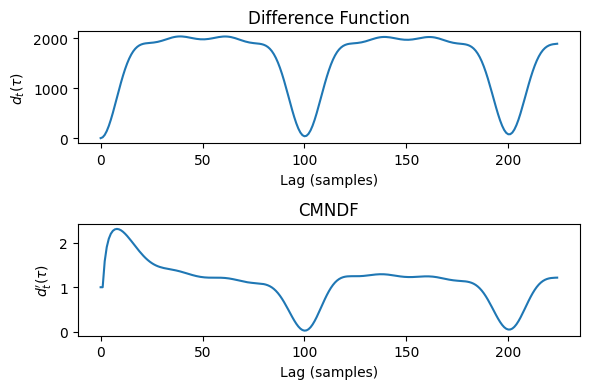

In [10]:
cmndf_frame, power_spec, amplitudes = cmndf(audio_frame, tau_max)

fig, axs = plt.subplots(2, 1, figsize=(6,4))

axs[0].plot(diff_fct)
axs[0].set_title("Difference Function")
axs[0].set_xlabel("Lag (samples)")
axs[0].set_ylabel("$d_t(\\tau)$")

axs[1].plot(cmndf_frame)
axs[1].set_title("CMNDF")
axs[1].set_xlabel("Lag (samples)")
axs[1].set_ylabel("$d_t^\\prime(\\tau)$")

plt.tight_layout()
plt.show()

### Computing trough locations

We can pick out the relative minima of the curve now and see what we get for the fundamental period estimates. We can easily do this using SciPy's `argrelmin` function.

We recall that each local minima point represents those lags with which the signal somewhat resembles itself. Hence, each one can be called a probable estimate for the fundamental period under which the audio signal seems to repeat itself. Again, the goal of pitch detection is to detect the fundamental frequency of the current audio wave, so we can take 1 / the x-value (lag, in samples) of any of these local minima to get our valid pitch estimates for the audio.

Freq estimates (Hz) from diff_fct: ['882.00', '441.00', '294.00', '220.50']
Freq estimates (Hz) from CMNDF: ['801.82', '441.00', '352.80', '290.13', '220.50']


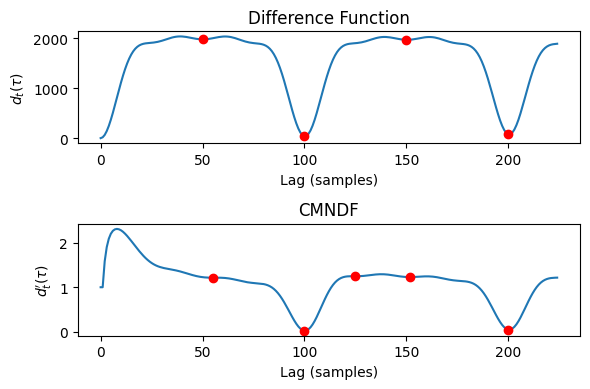

In [11]:
diff_trough_indices = scipy.signal.argrelmin(diff_fct, order=1)[0]
cmndf_trough_indices = scipy.signal.argrelmin(cmndf_frame, order=1)[0]

fig, axs = plt.subplots(2, 1, figsize=(6,4))

# plot the troughs from the difference function
axs[0].plot(diff_fct)
axs[0].set_title("Difference Function")
axs[0].plot(diff_trough_indices, diff_fct[diff_trough_indices], 'ro')
axs[0].set_xlabel("Lag (samples)")
axs[0].set_ylabel("$d_t(\\tau)$")

# print
pitch_estimates1 = [SAMPLE_RATE/x for x in diff_trough_indices]
print(f"Freq estimates (Hz) from diff_fct: {[f'{p:.2f}' for p in pitch_estimates1]}")

# plot the cmndf troughs
axs[1].plot(cmndf_frame)
axs[1].set_title("CMNDF")
axs[1].plot(cmndf_trough_indices, cmndf_frame[cmndf_trough_indices], 'ro')
axs[1].set_xlabel("Lag (samples)")
axs[1].set_ylabel("$d_t^\\prime(\\tau)$")

# print
pitch_estimates2 = [SAMPLE_RATE/x for x in cmndf_trough_indices]
print(f"Freq estimates (Hz) from CMNDF: {[f'{p:.2f}' for p in pitch_estimates2]}")

plt.tight_layout()
plt.show()

### Pitches! Multiple...

So for our audio, we have a couple pitch estimates, some of which resemble the true fundamental frequency (440Hz) and one of its harmonic multiples (880Hz).

```shell
Freq (Hz) from diff_fct: ['882.00', '441.00', '294.00', '220.50']
Freq (Hz) from CMNDF: ['801.82', '441.00', '352.80', '290.13', '220.50']
```

But a couple of problems:

1. We get some incorrect guesses as the waveform repeats itself. $294.00$ and $220.50 $represent the frequencies at which the $880$ and $440$ frequency waves come again.
2. We want to choose the actual fundamental frequency $F_0=440$ and not $880$.
3. The CMNDF's frequencies are slightly biased, and differ from the raw difference function.

### Inspecting the lags
To qualitatively assess which peaks seem more accurate, we can plot the effect of actually shifting the signals over by the lags and inspecting the difference.

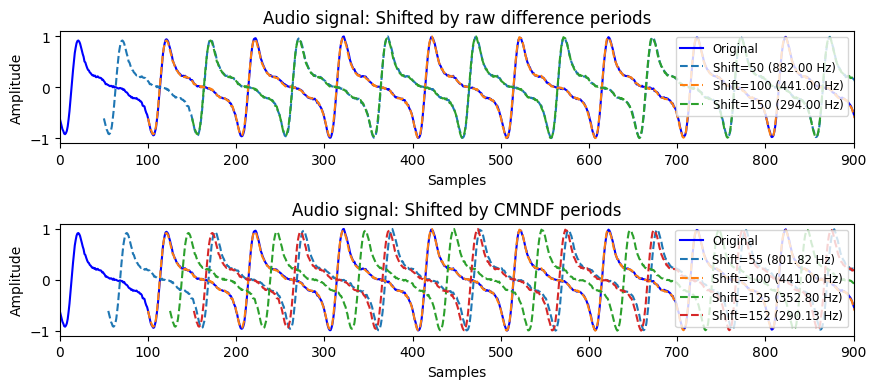

In [12]:
x_vals = np.arange(len(audio_frame))
shifted_x_vals1 = [x_vals + diff_trough_indices[i] for i in range(0, len(diff_trough_indices)-1)]
shifted_x_vals2 = [x_vals + cmndf_trough_indices[i] for i in range(0, len(cmndf_trough_indices)-1)]

fig, axs = plt.subplots(2, 1, figsize=(9,4))
axs[0].plot(x_vals, audio_frame, 'b-', label="Original")
axs[1].plot(x_vals, audio_frame, 'b-', label="Original")

for i, x_vals1 in enumerate(shifted_x_vals1):
    shift = diff_trough_indices[i]
    freq = SAMPLE_RATE / shift
    axs[0].plot(x_vals1, audio_frame, '--', label=f"Shift={shift} ({freq:.2f} Hz)")

for i, x_vals2 in enumerate(shifted_x_vals2):
    shift = cmndf_trough_indices[i]
    freq = SAMPLE_RATE / shift
    axs[1].plot(x_vals2, audio_frame, '--', label=f"Shift={shift} ({freq:.2f} Hz)")

axs[0].set_title("Audio signal: Shifted by raw difference periods")
axs[0].set_xlabel("Samples")
axs[0].set_ylabel("Amplitude")
axs[0].set_xlim(0, 900)

axs[1].set_title("Audio signal: Shifted by CMNDF periods")
axs[1].set_xlabel("Samples")
axs[1].set_ylabel("Amplitude")
axs[1].set_xlim(0, 900)

axs[0].legend(loc='upper right', fontsize='small')
axs[1].legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()

### Evaluation: Inspecting the lags
From the shifts, it seems like the raw difference function gives us the x-values which are more accurate to the actual sinusoidal behavior of the signal. This aligns with how we know the wave should contain 440 and 880 frequency components, instead of 800 frequency components.

This likely comes as an artefact from the $d_t^\prime(\tau=0)=1$ bias in the CMNDF which can lead to unexpected local minima that are less reflective of the true signal shape. (Another gripe with the CMNDF). Cheveigne and Kawahara, perhaps as a function of ego, push through and keep using the CMNDF anyways but instead deal with this by only using the CMNDF for absolute thresholding (the next step) and use the raw difference function's x-values for everything else.


## Step 2: Absolute thresholding

Now that we have our pitch estimates, how do we choose which pitch actually corresponds to the true fundamental frequency of the signal? We have an intuition that if the difference function is smaller at the given lag, then it is more likely to be the true fundamental frequency as more of the wave patterns will align than with those at subharmonic multiples.

**Absolute thresholding** tries to account for the problem of accidentally picking octave errors, which we saw as the minima of the difference function which occur at period multipels of the fundamental. We essentially go through all the possible pitch estmates in successive order from the smallest to the greatest 'lag', and then we choose the first one that is below a given difference threshold. If no estimates are below the threshold, we take the global minima as the pitch.

This is where we finally use our CMNDF's y-values to choose a particular pitch.

In [13]:
def absolute_threshold(cmndf_frame: np.ndarray, local_minima: list[int], threshold: float=0.1):
    """
    Apply the absolute thresholding step by searching for the first trough
    below a certain 'absolute threshold'

    Args:
        cmndf_frame: Output from applying CMNDF over a frame of audio samples
        local_minima: Indices of local minima of the raw diff_fct
        threshold: Take the first trough below this value of d'(tau)
    
    Returns:
        if possible, the first tau st. d'(tau) < threshold. Else, the x of the global minima
    """
    for min in local_minima:
        if cmndf_frame[min] <= threshold:
            return min
    
    # no min found below threshold, return the global minima
    global_min = np.argmin(cmndf_frame)
    return global_min

In [14]:
fundamental_period = absolute_threshold(cmndf_frame, diff_trough_indices, 0.1)
fundamental_freq = SAMPLE_RATE/fundamental_period
print(fundamental_freq)

441.0


## Step 3: Peak refinement with parabolic interpolation

The last step we will explore in the YIN algorithm is **parabolic interpolation** around each local minima to refine our final pitch estimate.

For parabolic interpolation, for each local minima we take three points - the minima + its two adjacent neighbors - then fit a parabola through the 3 points and take the x value for minima of the parabola as the new true fundamental period. 

The YIN paper (Cheveigne, Kawahara 2002) explains the reasoning in more detail, but the gist is that otherwise for periods that are not a multiple of the sampling period (eg, fits neatly within 44100 samples/sec) then the estimate may be incorrect by up to half the sampling period.

Again, recalling the slight bias from the $d_t^\prime(\tau=0)=1$ from the CMNDF, we interpolate based on the raw difference $d_t$ function rather than the CMNDF.

Our basic method is that given our 3 points:

$$(x-1, y_1), (x, y_2), (x+1, y_3)$$

We solve for the equation of the parabola passing through them by solving the system of 3 equations by plugging the points into the following equation:

$$y = Ax^2 + Bx + C$$

And then we get the following values for the interpolated $x_{\text{min}}$ and $y_{\text{max}}$ of the parabola.

$$
x_{\text{min}} = x + \frac{y_1 - y_3}{2(y_1 - 2y_2 + y_3)}
$$
$$
{\text{min}} = y_2 - \frac{(y_1 - y_3)^2}{4(y_1 - 2y_2 + y_3)}
$$

This allows us to refine the minimum point of the difference function and adds precision to our answers.

In [15]:
# note: njit is something to speed up the computation - useful for running
# the function multiple times across a long audio file
# in a real case i would include this
# @njit
def parabolic_interpolation(diff_fct: np.ndarray, trough_index: int) -> tuple[float, float]:
    """
    Perform parabolic interpolation around a minimum point using Numba for optimization.
    Done on diff_fct to avoid + bias for small lags from CMNDF.
    
    Args:
        diff_fct: A 1D array of y-values (e.g., diff_fct values).
        trough_index: The index of the minimum point in diff_frame.

    Returns:
        A tuple with the interpolated x & y coordinates of the minimum.
    """
    x = trough_index

    # don't interpolate at boundaries - need at least 3 points
    if x <= 0 or x >= len(diff_fct) - 1:
        return float(x), diff_fct[x]  
   
    y_1 = diff_fct[x - 1]
    y_2 = diff_fct[x]
    y_3 = diff_fct[x + 1]

    denominator = 2 * (y_1 - 2 * y_2 + y_3)
    if denominator == 0:
        return float(x), y_2
    
    x_interpolated = x + (y_1 - y_3) / denominator
    y_interpolated = y_2 - ((y_1 - y_3)**2) / (4 * denominator)

    return x_interpolated, y_interpolated

## Evaluate: The final pitch

### Interpolation: Effect
The paper says the process of interpolating had little effect on gross error rates over the database (0.77% vs 0.78%) but that when tested on synthetic stimuli, that it reduced fine errors at all $F_0$ and avoided gross errors at high $F_0$.

### Our result: Success!
We see that for our synthetic signal, that interpolation slightly improved our accuracy! We successfully recovered the original pitch, within some degree of certainty.

In [16]:
# interpolate + test the final pitch
interpolated_fundamental_period, _ = parabolic_interpolation(diff_fct, fundamental_period)
final_pitch = SAMPLE_RATE / interpolated_fundamental_period

EXPECTED_PITCH = 440.0 # hz
np.testing.assert_almost_equal(final_pitch, EXPECTED_PITCH, decimal=1)

print(f"Test passed! Final pitch estimate is {final_pitch:.2f} Hz (expected ~440 Hz)")


Test passed! Final pitch estimate is 440.06 Hz (expected ~440 Hz)


### Step 4: "Best local estimate" (omitted)

There is a final step in the YIN algorithm, which is to find the 'best local estimate' by rerunning the algorithm on different window sizes of successively smaller values around a point if we are at an inflection point in the pitch curve where the pitch is changing within the frame. However for the sake of time (because this project is long enough as is) and since we see how the fundamental idea of the algorithm works on a single frame, I will omit this step. But the details are in the paper (step 6) if you are interested to see how they deal with inflection points.

## Overall: Success!

The project successfully detected the pitch of a synthetic audio signal with realistic harmonic overtone complexity, such that it mirror show actual musical signals look. The final pitch estimate of $440.06$ Hz is within 1 degree of precision compared to the expected value of $440$ Hz, which is within an undetectable level of tolerance to the human ear!

The numerical results are trustworthy because I verified each step of the implementation. The autocorrelation results, differnce function, and interpolation all come together to enable the final pitch estimate to come together - without any of these components, the final pitch would not be as accurate or even within the same ballpark as what we got - so I am fairly confident that the method itself is okay.

Every stage / validation of the process is documented more in-depth in the Implementation section.

### Reflection

Working on this project reinforced how signal processing is such a deep and complex topic. Even though I use a tuner app every day, I didn't expect the math behind getting a simple pitch would be so complicated. Reading through the YIN paper was honestly humbling and a lesson in extreme patience.

### Next steps

I have a couple ideas for next steps for further learning:

1. Scaling the YIN algorithm across an entire audio file, or noisier signals
2. Improving the CMNDF step - While YIN's CMNDF solution avoids picking small lags, the approach is pretty convoluted and we still use the difference function for the ground truth fundamental periods. I wonder if there is a simpler solution.
3. Exploring alternate machine learning / CNN-based methods for pitch detection as well, and seeing how they compare to the more traditional approach.
4. Unpacking the math behind the FFT and the Wiener-Khinchin theorem, instead of black-boxing it as I did for this project.
5. Exploring polyphonic pitch detection algorithms.
6. Finally, some music visualization / smart-home music visualization projects would be cool. Maybe with a Raspberry Pi?

Thank you for reading through my long project.

### References

[1] A. de Cheveigné and H. Kawahara, "YIN, a fundamental frequency estimator for speech and music," *J. Acoust. Soc. Am.*, vol. 111, no. 4, pp. 1917–1930, Apr. 2002, doi: 10.1121/1.1458024.

[2] E. W. Weisstein, “Wiener-Khinchin Theorem,” *MathWorld--A Wolfram Web Resource*. Accessed: Apr. 12, 2024. [Online]. Available: https://mathworld.wolfram.com/Wiener-KhinchinTheorem.html